In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import time
import tqdm
import random
import argparse

import numpy as np
import pandas as pd
tqdm.tqdm.pandas()

import matplotlib.pyplot as plt

import gensim
from gensim import corpora, models, similarities

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from lightgbm import LGBMClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
set_seed(42)

In [3]:
df = pd.read_csv("/mnt/d/work2/teknofest-tddi/data/processed/cleaned.csv")
df = df.dropna()
df = df.reset_index(drop=True)

In [4]:
df.head()

,rid,sid,app,review,sentiment,aspect,aspect_polarity,cleaned,text
0,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
1,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
2,10,1,Google Play Store/BiP,Her güncellemede daha da kötüleşen Turkcell in...,Negative,Turkcell,0,güncellemede kötüleşen Turkcell in ara ara ken...,Turkcell güncellemede kötüleşen Turkcell in ar...
3,13,1,Google Play Store/BiP,BiP’ten aranmıyor yardım,Negative,BiP’ten,0,BiPten aranmıyor yardım,BiP’ten BiPten aranmıyor yardım
4,17,1,Google Play Store/BiP,Bu yorumum kesinlikle uygulamanın daha çok gel...,Positive,BİP,2,yorumum uygulamanın gelişmesi kulanıcıya erişi...,BİP yorumum uygulamanın gelişmesi kulanıcıya e...


In [5]:
df["text"] = df["aspect"] + " " + df["cleaned"]

In [6]:
X = df["text"]
y = df["aspect_polarity"]

In [7]:
def train_validate_test_split(df, split_size):
    perm = np.random.permutation(df.index)
    train_end = int(split_size * len(df.index))
    validate_end = int(((1 - split_size) / 2) * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [8]:
df_train, df_validation, df_test = train_validate_test_split(df, split_size=0.9)

In [9]:
X_train = df_train["text"]
y_train = df_train["aspect_polarity"]

In [10]:
X_valid = df_validation["text"]
y_valid = df_validation["aspect_polarity"]

In [11]:
X_test = df_test["text"]
y_test = df_test["aspect_polarity"]

In [12]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train).astype('float32')
X_valid_tfidf = tfidf.transform(X_valid).astype('float32')
X_test_tfidf = tfidf.transform(X_test).astype('float32')

In [14]:
lgbm = LGBMClassifier()
lgbm_tfidf_train_start = time.time()
lgbm.fit(X_train_tfidf, y_train)
lgbm_tfidf_train_time = time.time() - lgbm_tfidf_train_start
print(f"LGBM + TFIDF Train Time = {lgbm_tfidf_train_time:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.401730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442517
[LightGBM] [Info] Number of data points in the train set: 145933, number of used features: 11237
[LightGBM] [Info] Start training from score -0.592508
[LightGBM] [Info] Start training from score -2.974934
[LightGBM] [Info] Start training from score -0.926315
LGBM + TFIDF Train Time = 26.8676


In [15]:
lgbm_tfidf_pred_train = lgbm.predict(X_train_tfidf)
lgbm_tfidf_test_start = time.time()
lgbm_tfidf_pred_test = lgbm.predict(X_test_tfidf)
lgbm_tfidf_test_time = time.time() - lgbm_tfidf_test_start

lgbm_tfidf_train_score = accuracy_score(lgbm_tfidf_pred_train, y_train)
lgbm_tfidf_test_score = accuracy_score(lgbm_tfidf_pred_test, y_test)
print(f"LGBM + TFIDF Train Score = {lgbm_tfidf_train_score * 100:.4f}%")
print(f"LGBM + TFIDF Test Score = {lgbm_tfidf_test_score * 100:.4f}%")
print(f"LGBM + TFIDF Test Time = {lgbm_tfidf_test_time:.4f}")

LGBM + TFIDF Train Score = 77.2190%
LGBM + TFIDF Test Score = 76.0730%
LGBM + TFIDF Test Time = 0.0573


In [16]:
lgbm_tfidf_precision_score = precision_score(y_test, lgbm_tfidf_pred_test, average='macro')
lgbm_tfidf_f1_score = f1_score(y_test, lgbm_tfidf_pred_test, average='macro')
lgbm_tfidf_recall_score = recall_score(y_test, lgbm_tfidf_pred_test, average='macro')
lgbm_tfidf_accuracy_score = accuracy_score(y_test, lgbm_tfidf_pred_test)

print(f"LGBM + TFIDF Precision Score = {lgbm_tfidf_precision_score * 100:.4f}%")
print(f"LGBM + TFIDF F1 Score = {lgbm_tfidf_f1_score * 100:.4f}%")
print(f"LGBM + TFIDF Recall Score = {lgbm_tfidf_recall_score * 100:.4f}%")
print(f"LGBM + TFIDF Accuracy Score = {lgbm_tfidf_accuracy_score * 100:.4f}%")

LGBM + TFIDF Precision Score = 75.7066%
LGBM + TFIDF F1 Score = 53.9947%
LGBM + TFIDF Recall Score = 53.6944%
LGBM + TFIDF Accuracy Score = 76.0730%


In [17]:
print(classification_report(y_test, lgbm_tfidf_pred_test, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.76      0.88      0.81      4508
     Neutral       0.75      0.04      0.08       421
    Positive       0.76      0.69      0.72      3179

    accuracy                           0.76      8108
   macro avg       0.76      0.54      0.54      8108
weighted avg       0.76      0.76      0.74      8108



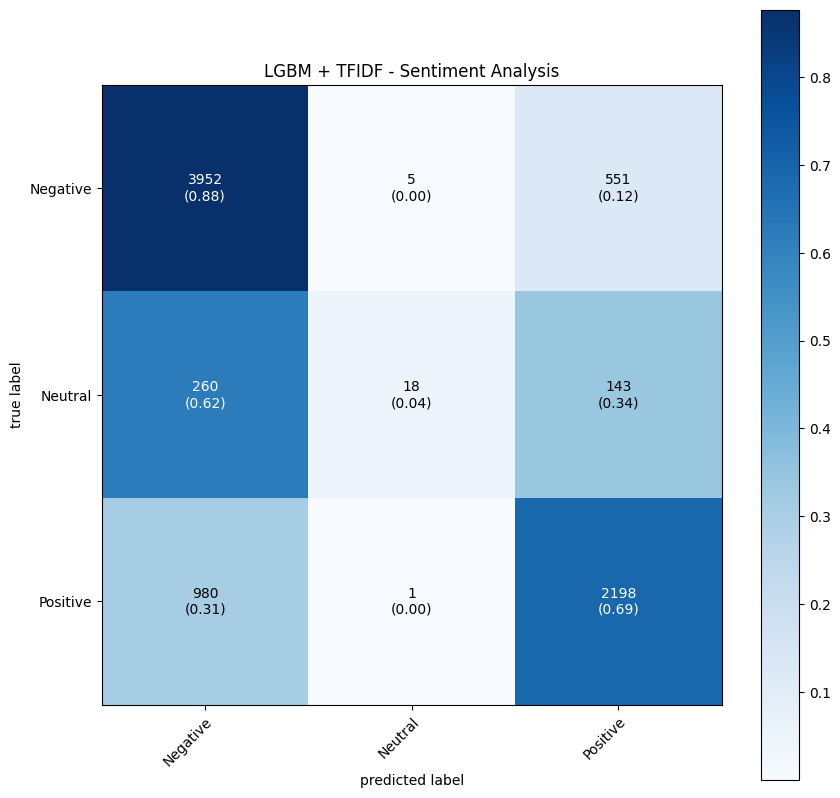

In [18]:
lgbm_cm = confusion_matrix(y_test, lgbm_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=lgbm_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["Negative", "Neutral", "Positive"], figsize=(10, 10))
plt.title("LGBM + TFIDF - Sentiment Analysis")
plt.savefig("./output/lgbm_tfidf.png")
plt.show()